In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import MinMaxScaler

from sklearn import datasets
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

from scipy import interp
from itertools import cycle
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from xgboost import plot_importance
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/ml-fraud/data_fraud

/content/drive/MyDrive/ColabNotebooks/ml-fraud/data_fraud


In [ ]:
X_train = pd.read_csv('X_train.csv')
X_train = X_train.drop('Unnamed: 0', axis = 1)
y_train = np.load("y_train.npy")
X_test = pd.read_csv('X_test.csv')
X_test = X_test.drop(['Unnamed: 0'], axis = 1)
y_test = np.load("y_test.npy")

In [ ]:
# a dictionary for keeping all scores of the classifiers
recall_scores = {'test':{'LightGBM': 0, 'XGBoost' :0, 'RF' : 0, 'EN_model' : 0}}
auc_scores = {'test':{'LightGBM': 0, 'XGBoost' :0, 'RF' : 0, 'EN_model' : 0}}
#XGB
xg_00 = xgb.XGBClassifier()
xg_00.fit(X_train, y_train)
predictions_xg = xg_00.predict(X_test)
predictions_xg = np.where(predictions_xg > 0.5, 1, 0) #Turn probability to 0-1 binary output

#LightGBM
clf_00 = lgb.LGBMClassifier()
clf_00.fit(X_train, y_train)
predictions_lgb = clf_00.predict(X_test)
predictions_lgb = np.where(predictions_lgb > 0.5, 1, 0) #Turn probability to 0-1 binary output

#RF
rfc_00 = RandomForestClassifier()
rfc_00.fit(X_train, y_train)
predictions_rfc =rfc_00.predict(X_test)
predictions_rfc = np.where(predictions_rfc > 0.5, 1, 0) #Turn probability to 0-1 binary output


# We will perform soft voting:
ensemble_results_00 = (predictions_xg + predictions_lgb + predictions_rfc)/3
ensemble_results_00[:5]
class_ensemble_results = [1 if i > 0.5 else 0 for i in ensemble_results_00]
recall_scores["test"]["EN_model"] = round(recall_score(y_test, class_ensemble_results), 3)
auc_scores["test"]["EN_model"] = round(roc_auc_score(y_test, class_ensemble_results), 3)

print('recall_scores: ', recall_scores)
print('\n')
print('auc_scores: ', auc_scores)

recall_scores:  {'test': {'LightGBM': 0, 'XGBoost': 0, 'RF': 0, 'EN_model': 0.774}}


auc_scores:  {'test': {'LightGBM': 0, 'XGBoost': 0, 'RF': 0, 'EN_model': 0.775}}


In [ ]:
pip install shap

     |████████████████████████████████| 371 kB 29.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509242 sha256=a18034d80e12488c1c2b0274c1aaf569d2af445937a93e2465da97e418c6019e
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


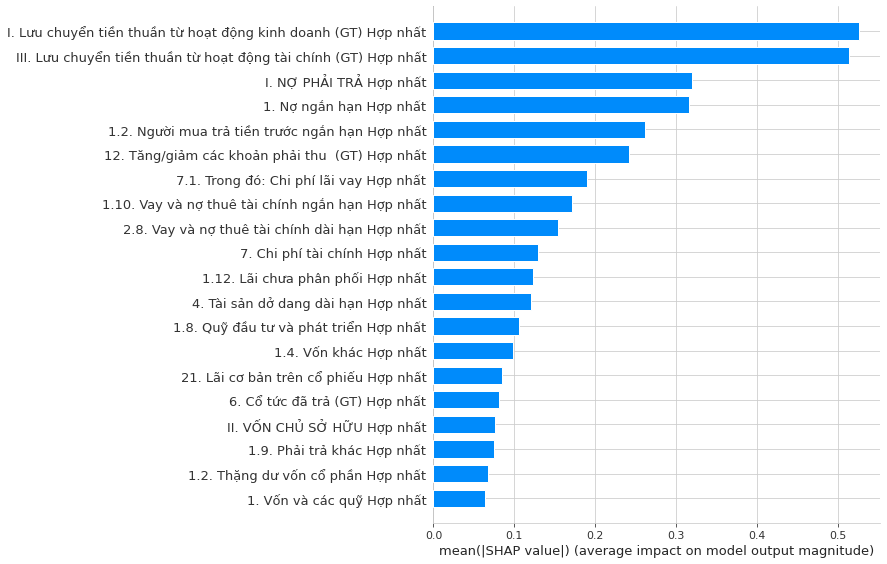

In [ ]:
import shap

xg_00 = XGBClassifier(random_state=0)
xg_00.fit(X_train,y_train)
xg00_shap_values = shap.TreeExplainer(xg_00).shap_values(X_test)

clf_00 = lgb.LGBMClassifier()
clf_00.fit(X_train, y_train)
lg00_shap_values = shap.TreeExplainer(clf_00).shap_values(X_test)[1]

rfc_00 = RandomForestClassifier()
rfc_00.fit(X_train, y_train)
rf00_shap_values = shap.TreeExplainer(rfc_00).shap_values(X_test)[1]

mean_shap_values = (xg00_shap_values + lg00_shap_values + rf00_shap_values )/3

shap.summary_plot(mean_shap_values, X_test, plot_type="bar")

In [ ]:
shap_sum = np.round((np.abs(rf00_shap_values[1]).mean(axis=0) + np.abs(xg00_shap_values).mean(axis=0) + np.abs(lg00_shap_values[1]).mean(axis=0))/3,3)

X_importance = X_test
importance_rf = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_rf.columns = ['column_name', 'shap_importance']
importance_rf = importance_rf.sort_values('shap_importance', ascending=False)
importance_rf.head(20)

,column_name,shap_importance
148,I. Lưu chuyển tiền thuần từ hoạt động kinh doa...,0.201
177,III. Lưu chuyển tiền thuần từ hoạt động tài ch...,0.196
66,I. NỢ PHẢI TRẢ Hợp nhất,0.136
67,1. Nợ ngắn hạn Hợp nhất,0.124
69,1.2. Người mua trả tiền trước ngắn hạn Hợp nhất,0.118
160,12. Tăng/giảm các khoản phải thu (GT) Hợp nhất,0.112
77,1.10. Vay và nợ thuê tài chính ngắn hạn Hợp nhất,0.101
90,2.8. Vay và nợ thuê tài chính dài hạn Hợp nhất,0.1
130,7.1. Trong đó: Chi phí lãi vay Hợp nhất,0.092
112,1.12. Lãi chưa phân phối Hợp nhất,0.071


In [ ]:
shap.TreeExplainer(clf_00)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
explainer = shap.TreeExplainer(clf_00)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value[1], mean_shap_values[0,:], X_train.iloc[0,:])

In [ ]:
dfT = pd.read_excel('Fraud2020_1.xlsx')
dfT.head() 

In [ ]:

dfT = dfT.drop(['Mã CK', 'Sàn', 'Tên', 'STT'], axis=1)
#Replace NaN by 0
dfT = dfT.fillna(0)
dfT

In [ ]:
x_test_2020 = dfT
#x_test_2020 = x_test_2020.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_test_2020

,I. TÀI SẢN NGẮN HẠN Hợp nhất,1. Tiền và tương đương tiền Hợp nhất,1.1. Tiền Hợp nhất,1.2. Các khoản tương đương tiền Hợp nhất,2. Đầu tư tài chính ngắn hạn Hợp nhất,2.1. Chứng khoán kinh doanh Hợp nhất,2.2. Dự phòng giảm giá chứng khoán kinh doanh Hợp nhất,2.3. Đầu tư nắm giữ đến ngày đáo hạn Hợp nhất,3. Các khoản phải thu ngắn hạn Hợp nhất,3.1. Phải thu ngắn hạn của khách hàng Hợp nhất,3.2. Trả trước cho người bán ngắn hạn Hợp nhất,3.3. Phải thu nội bộ ngắn hạn Hợp nhất,3.4. Phải thu theo tiến độ kế hoạch hợp đồng xây dựng Hợp nhất,3.5. Phải thu về cho vay ngắn hạn Hợp nhất,3.6. Phải thu ngắn hạn khác Hợp nhất,3.7. Dự phòng phải thu ngắn hạn khó đòi Hợp nhất,3.8. Tài sản thiếu chờ xử lý Hợp nhất,"4. Hàng tồn kho, ròng Hợp nhất",4.1. Hàng tồn kho Hợp nhất,4.2. Dự phòng giảm giá HTK Hợp nhất,5. Tài sản ngắn hạn khác Hợp nhất,5.1. Chi phí trả trước ngắn hạn Hợp nhất,5.2. Thuế GTGT được khấu trừ Hợp nhất,5.3. Thuế và các khoản khác phải thu Nhà nước Hợp nhất,5.4. Giao dịch mua bán lại trái phiếu chính phủ Hợp nhất,5.5. Tài sản ngắn hạn khác Hợp nhất,II. TÀI SẢN DÀI HẠN Hợp nhất,1. Phải thu dài hạn Hợp nhất,1.1. Phải thu khách hang dài hạn Hợp nhất,1.2. Trả trước người bán dài hạn Hợp nhất,1.3. Vốn kinh doanh ở các đơn vị trực thuộc Hợp nhất,1.4. Phải thu nội bộ dài hạn Hợp nhất,1.5. Phải thu về cho vay dài hạn Hợp nhất,1.6. Phải thu dài hạn khác Hợp nhất,1.7. Dự phòng phải thu dài hạn Hợp nhất,2. Tài sản cố định Hợp nhất,2.1. GTCL TSCĐ hữu hình Hợp nhất,2.1.1. Nguyên giá TSCĐ hữu hình Hợp nhất,2.1.2. Khấu hao lũy kế TSCĐ hữu hình Hợp nhất,2.2. GTCL Tài sản thuê tài chính Hợp nhất,...,1. Lợi nhuận trước thuế (GT) Hợp nhất,2. Khấu hao TSCĐ và BĐSĐT (GT) Hợp nhất,3. Phân bổ lợi thế thương mại (GT) Hợp nhất,4. Chi phí dự phòng (GT) Hợp nhất,5. Lãi/lỗ chênh lệch tỷ giá hối đoái do đánh giá lại các khoản mục tiền tệ có gốc ngoại tệ (GT) Hợp nhất,6. Lãi/lỗ từ thanh lý tài sản cố định (GT) Hợp nhất,7. Lãi/lỗ từ hoạt động đầu tư (GT) Hợp nhất,8. Chi phí lãi vay (GT) Hợp nhất,9. Thu lãi và cổ tức (GT) Hợp nhất,10. Các khoản điều chỉnh khác (GT) Hợp nhất,11. Lợi nhuận từ hoạt động kinh doanh trước thay đổi vốn lưu động (GT) Hợp nhất,12. Tăng/giảm các khoản phải thu (GT) Hợp nhất,13. Tăng/giảm hàng tồn kho (GT) Hợp nhất,14. Tăng/giảm các khoản phải trả (GT) Hợp nhất,15. Tăng/giảm chi phí trả trước (GT) Hợp nhất,16. Tăng/giảm chứng khoán kinh doanh (GT) Hợp nhất,17. Chi phí lãi vay đã trả (GT) Hợp nhất,18. Thuế thu nhập doanh nghiệp đã trả (GT) Hợp nhất,19. Tiền thu khác từ các hoạt động kinh doanh (GT) Hợp nhất,20. Tiền chi khác từ các hoạt động kinh doanh (GT) Hợp nhất,II. Lưu chuyển tiền thuần từ hoạt động đầu tư (GT) Hợp nhất,"1. Tiền chi để mua sắm, xây dựng TSCĐ và các tài sản dài hạn khác (GT) Hợp nhất","2. Tiền thu từ thanh lý, nhượng bán TSCĐ và các tài sản dài hạn khác (GT) Hợp nhất","3. Tiền chi cho vay, mua các công cụ nợ của đợn vị khác (GT) Hợp nhất","4. Tiền thu hồi cho vay, bán lại các công cụ nợ của đơn vị khác (GT) Hợp nhất",5. Tiền chi đầu tư góp vốn vào đơn vị khác (GT) Hợp nhất,6. Tiền thu hồi đầu tư góp vốn vào đơn vị khác (GT) Hợp nhất,"7. Tiền thu lãi cho vay, cổ tức và lợi nhuận được chia (GT) Hợp nhất",III. Lưu chuyển tiền thuần từ hoạt động tài chính (GT) Hợp nhất,"1. Tiền thu từ phát hành cổ phiếu, nhận góp vốn của chủ sở hữu (GT) Hợp nhất","2. Tiền trả lại vốn góp cho các chủ sở hữu, mua lại cổ phiếu của doanh nghiệp đã phát hành (GT) Hợp nhất",3. Tiền thu được các khoản đi vay (GT) Hợp nhất,4. Tiền trả nợ gốc vay (GT) Hợp nhất,5. Tiền thanh toán vốn gốc đi thuê tài chính (GT) Hợp nhất,6. Cổ tức đã trả (GT) Hợp nhất,7. Tiền lãi đã nhận (GT) Hợp nhất,IV. Lưu chuyển tiền thuần trong kỳ (GT) Hợp nhất,V. Tiền và tương đương tiền đầu kỳ (GT) Hợp nhất,VI. Ảnh hưởng của chênh lệch tỷ giá (GT) Hợp nhất,VII. Tiền và tương đương tiền cuối kỳ (GT) Hợp nhất
0,2.999722e+13,1.279251e+13,2.927812e+11,1.249973e+13,9.581660e+11,0.000000e+00,0.000000e+00,9.581660e+11,7.814097e+12,7.634855e+12,1.164483e+11,0.0,0.0,0.0,5.925916e+10,-

In [ ]:
x_test_lgb2020  = x_test_2020
x_test_xg2020  = x_test_2020
x_test_rfc2020  = x_test_2020

 #Predict on test set
predictions_lgbm_prob = clf_00.predict(x_test_lgb2020)
predictions_lgbm_01 = np.where(predictions_lgbm_prob >= 0.5, 1, 0) #Turn probability to 0-1 binary output
predictions_lgbm_01
print(sum(i == 1 for i in predictions_lgbm_01))

predictions_xg_prob = xg_00.predict(x_test_xg2020)
predictions_xg_01 = np.where(predictions_xg_prob >= 0.5, 1, 0) #Turn probability to 0-1 binary output
print(sum(i == 1 for i in predictions_xg_01))

predictions_rfc_prob = rfc_00.predict(x_test_rfc2020)
print(sum(i == 0 for i in predictions_rfc_prob))

# We will perform soft voting:
ensemble_results = (predictions_xg_01 + predictions_lgbm_01 + predictions_rfc_prob)/3
ensemble_results[:5]
class_ensemble_results = [1 if i > 0.5 else 0 for i in ensemble_results]

sum(i == 1 for i in class_ensemble_results)

234
303
1559


212

In [ ]:
df1 = pd.read_excel('Fraud2020_1.xlsx')
df1['fraud'] = class_ensemble_results
df2 = df1[['Mã CK', 'Tên', 'fraud']]
df2 = df2.rename({'Mã CK': 'Ticker'}, axis=1)
df2.head()

,Ticker,Tên,fraud
0,BSR,Lọc - Hóa dầu Bình Sơn,0
1,OIL,PV Oil,0
2,PEQ,Thiết bị xăng dầu Petrolimex,0
3,PLX,Petrolimex,0
4,POS,Bảo dưỡng công trình DK biển,0


In [ ]:
df2.groupby('fraud').count()

,Ticker,Tên
fraud,,
0,1348,1348
1,212,212


In [ ]:

df3 = pd.read_excel('PAT_1920.xlsx')
df3 = df3.drop(columns=['Unnamed: 0'])
df3 = df3[df3['YearReport'] == 2020]
df3.head()

,Ticker,YearReport,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Trước kiểm toán,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Sau kiểm toán,Difference,Ratio
2182,AAA,2020,2.833723e+11,2.831728e+11,-1.995170e+08,-0.07
2183,AAM,2020,-1.196656e+10,-1.196735e+10,-7.864020e+05,0.01
2184,AAS,2020,3.323098e+09,3.323098e+09,0.000000e+00,0.00
2185,AAT,2020,1.573726e+10,1.403847e+10,-1.698790e+09,-10.79
2186,AAV,2020,1.438229e+10,1.438229e+10,2.000000e+00,0.00


In [ ]:
df3.shape

(1120, 6)

In [ ]:
df4 = pd.merge(df3,df2,on=['Ticker'])
df4

,Ticker,YearReport,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Trước kiểm toán,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Sau kiểm toán,Difference,Ratio,Tên,fraud
0,AAA,2020,2.833723e+11,2.831728e+11,-1.995170e+08,-0.07,An Phát Bioplastics,1
1,AAM,2020,-1.196656e+10,-1.196735e+10,-7.864020e+05,0.01,Thủy sản Mekong,0
2,AAT,2020,1.573726e+10,1.403847e+10,-1.698790e+09,-10.79,Tiên Sơn Thanh Hóa,0
3,ABC,2020,3.544989e+10,-1.775049e+11,-2.129548e+11,-600.72,Truyền thông VMG,0
4,ABR,2020,2.410013e+10,2.472864e+10,6.285094e+08,2.61,Đầu tư Nhãn Hiệu Việt,0
...,...,...,...,...,...,...,...,...
936,XHC,2020,4.134213e+10,4.125760e+10,-8.453318e+07,-0.20,Nội thất Xuân Hòa,0
937,XMC,2020,1.291763e+11,1.265777e+11,-2.598595e+09,-2.01,Bê tông Xuân Mai,1
938,XMP,2020,8.292512e+09,8.292512e+09,0.000000e+00,0.00,Thủy điện Xuân Minh,0
939,YBM,2020,1.350447e+10,1.327986e+10,-2.246126e+08,-1.66,Khoáng sản CN Yên Bái,0


In [ ]:
df4.to_excel('PAT_Fraud.xlsx')

In [ ]:
df4.groupby('fraud').count()

,Ticker,YearReport,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Trước kiểm toán,18. Lợi nhuận sau thuế thu nhập doanh nghiệp Sau kiểm toán,Difference,Ratio,Tên
fraud,,,,,,,
0,781,781,778,781,778,778,781
1,160,160,160,160,160,160,160
